# Galaxy Merger Simulation of Two Disk Galaxies
\
This program shows the user how to set up and run a simulation between two disk galaxies, and how to complete a preliminary analysis of the results. The disk galaxy models were generated using the Agama package (Vasiliev, 2018), and are in quasi-equilibrium when simulated in isolation. Due to the algorithm scaling as O(N$^2$), many of the important components found in spiral galaxies such as gas, dark matter, central black hole, and bulge were omitted, which are integral in keeping the model in equilibrium. This program simulates the interaction between a 10:1 merger of a larger galaxy and a smaller satellite galaxy in a violent collision event.

N-body simulations work by calculating the motion of each particle through time and space based on the mutual softened gravitational attraction from all the other particles in the simulation using equation (1). Thus, similarly to chaotic systems and other numerical integration problems, N-body simulations are heavily dependent on the initial conditions of the simulation. As such, most of the work in running simulations is coming up with a suitable set of initial conditions.
$$
g_{i} = -G\sum_{j\ne i}m_{j}\frac{r_{i}-r_{j}}{(|r_{i}-r_{j}|^{2} + \epsilon^{2} )^{3/2}} \qquad (1)
$$
***
Please ensure MSG_Nbody is installed via pip before running the program. 

***
## Table of Contents:
### Steps in running a simulation:
- load initial conditions and create copies for the host and satellite galaxy
- scale the positions, velocities, and masses of the host and satellite galaxy relative to each other; e.i. make the host galaxy 10x more massive
- add disk inclination if desired
- set the galaxies on a collision course
- merge the initial conditions into 3 contiguous NumPy arrays
- run the simulation and analyze the results!

In [2]:
from MSG_Nbody import *

## Loading initial conditions:
To save computational time, the initial conditions of the spiral galaxy have been precomputed and can be read into Python as a .txt file. Initial conditions for N-body simulations require initial positions, velocities, and masses of each particle in the simulation. For clarity, we will store each parameter in a separate array. For N particles, the position and velocity arrays should have dimensions of N x 3 (this simulation is in 3 dimensions) while masses N x 1. However, the initial conditions provided are stored in an N x 7 array $(x, y, z, v_x, v_y, v_z, m)$ and therefore need to be reshaped. We will write a function to do this efficiently.

In [3]:
# load in initial positions, velocities, and masses for host galaxy
host_pos, host_vel, host_mass = load_initial_conditions('initial_conditions/model_disk_3000')
# print final host galaxy mass
print(f'final host disk galaxy mass: {np.sum(host_mass)}')

final host disk galaxy mass: 2.573805180000001


## Scaling initial conditions
Now that the initial conditions are loaded into Python, we can scale them to create different galaxy models. For this simulation, a smaller 'satellite' galaxy will merge with a larger, more massive 'host' galaxy. We will write another function that scales the positions, velocities, and masses. In this simulation, the mass ratio between the host galaxy and the satellite galaxy is ~10 : 1.

In [4]:
# initiate satellite galaxy 
initial_mass = np.sum(host_mass)

# divide by the total mass to normalize the satellite galaxy mass
R = 1/initial_mass
M = 1/initial_mass
sat_pos, sat_vel, sat_mass = scale_initial_positions(host_pos, host_vel, host_mass, R, M)
# scale host galaxy initial conditions
host_pos, host_vel, host_mass = scale_initial_positions(host_pos, host_vel, host_mass, 1.0, 3.9)

print(f'final satellite disk galaxy mass: {np.sum(sat_mass)}')
print(f'final host disk galaxy mass: {np.sum(host_mass)}')

final satellite disk galaxy mass: 0.9999999999999993
final host disk galaxy mass: 10.037840201999998


## Adding disk inclination to the galaxy model
We can also rotate the disk about a specified axis using a rotation matrix, which will rotate the disk around the $x, y,$ or $z$ axis. In this example, we will rotate the satellite galaxy around the $y$ axis by 45º.

In [6]:
# rotate around y axis by 45º
sat_pos, sat_vel = rotate_disk(sat_pos, sat_vel, 45, 'y')

## Set galaxies on a collision course
Both galaxies are by default located at the origin. Thus, we must move the satellite galaxy far from the host galaxy by adding the coordinates of where we want to place it to its position array. We then add a velocity vector to the velocity array of the satellite galaxy pointing in the direction of the host galaxy to set them on a collision course. This vector must be less than the escape velocity of the satellite galaxy if the two galaxies are to merge. We can calculate the escape velocity easily with the escape_v function. For this simulation, we will place the satellite galaxy 40 units away in the x and y direction from the host galaxy.

In [7]:
# calculate the escape velocity of the satellite galaxy placed at x=50,y=50,z=40
P0 = [50.0, 50.0, 40.0]
escape_velocity = compute_escape_velocity(P0[0], P0[1], P0[2], np.sum(host_mass))
print(f'escape velocity: {escape_velocity}')

escape velocity: 0.49710616907788746


The magnitude of the escape velocity is ~0.5, which can be divided into $vx, vy$, and $vz$ components. To keep things simple, we will keep the host galaxy at rest and set the satellite galaxy on an elliptical orbit into the host galaxy. We can keep the host galaxy at rest if we assume we are in the frame of reference of the host galaxy.

In [8]:
V0 = [-0.42, 0.0, 0.0]
print('magnitude of satellite galaxy trajectory velocity: ', np.sqrt(V0[0]**2 + V0[1]**2 + V0[2]**2))
# move satellite galaxy to its initial position
sat_pos += P0
# give the satellite galaxy a velocity in the negative x direction less than the escape velocity to put it on a collision path
# the velocity is negative because, from the satellite galaxy, the host galaxy is in the negative x direction
sat_vel += V0
# flip the direction of rotation of the host galaxy for stronger gravitational tidal forces
host_vel = host_vel*-1

magnitude of satellite galaxy trajectory velocity:  0.42


## Merge the arrays into master position, velocity, and mass arrays
To ensure Numba works properly, it is advantageous to create contiguous NumPy arrays which store the data in the same physical memory location on your computer for faster computation times. This is done easily in NumPy with the function below.

In [9]:
pos_list = [host_pos, sat_pos]
vel_list = [host_vel, sat_vel]
mass_list = [host_mass, sat_mass]
positions, velocities, masses = concatenate_initial_conditions(pos_list, vel_list, mass_list, save_2_disk=True)

positions shape: (6000, 3), velocities shape: (6000, 3), masses shape: (6000, 1) total simulation mass: 11.037840201999998


Printing the shape of the position, velocity, and mass arrays, we can see they are now a combination of both galaxies' initial conditions. Since each galaxy had a particle count of N = 3000, the total particle count is now 6,000. We also see the total simulation mass is 11 which makes sense since we are simulating a 10:1 merger.

## Visualizing the simulation setup
before running an expensive simulation, we should verify visually that everything is as it should be! We can create a function to graph simulation snapshots easily which will also be useful when analyzing the results.

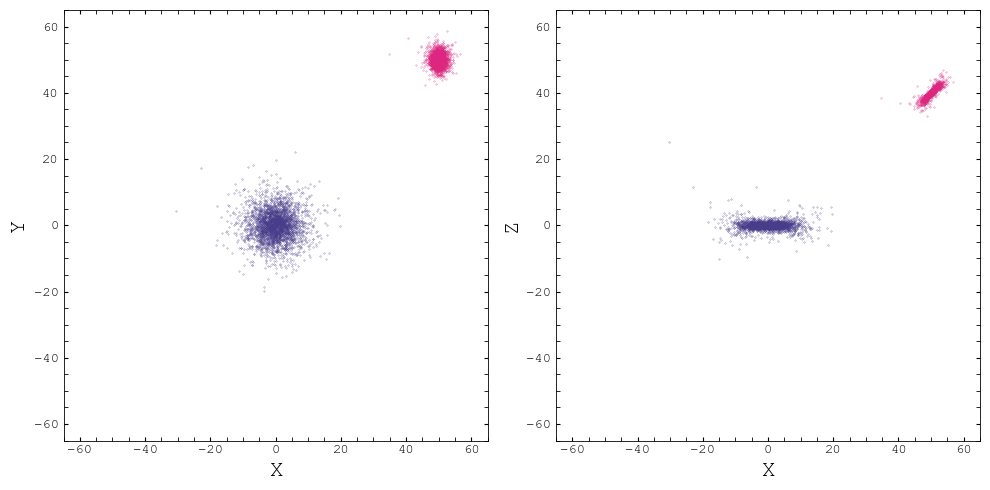

In [12]:
# display the initial simulation setup!
galaxies = [host_pos[np.newaxis,:,:], sat_pos[np.newaxis,:,:]]
display_galaxies(galaxies, 0, scale=65)

# Run the Simulation!
## N-body Simulation Code
This function is responsible for integrating the motion of each particle and is the main simulation loop. With each piece of the simulation ready, we can run the simulation and then animate the results! This will require substantial CPU operations and RAM to run. If you don't want to run the simulation on your laptop, you can alternatively download the snapshots that I precomputed on my laptop to finish the guide.
***
Running this cell will slam multiple CPU cores and take up considerable RAM. This simulation took about 20 minutes on my M2 macbook air with 16GB of RAM. The progress bar gives you a good estimate of the remaining computation time, as well as iterations per second. There will be an initial header where the just-in-time Numba compiler has to compile the program into machine code for faster execution. After this, the progress bar should appear. The function will automatically create a directory to save simulation snapshots!

In [14]:
# run N-body simulation
MSG_nbody(positions, velocities, masses, 0.1, 2000, snapshot_save_rate=10)

simulation running....  /ᐠ –ꞈ –ᐟ\<[pls be patient]


100%|███████████████████████████████████████| 2000/2000 [24:08<00:00,  1.38it/s]


'simulation complete [yay!!! (ﾐΦ ﻌ Φﾐ)✿ *ᵖᵘʳʳ*]'

# Viewing the Simulation
We must now load the snapshots back into Python by looping through each timestep and saving it to an array. We will write a function that outputs separate position, velocity, and potential arrays for each galaxy. The array will have 3 indexes, one for timesteps, one for number of particles, and one for number of dimensions ($x, y, z$)

In [16]:
directory = '/Users/elkosepicnewcomputer/Desktop/code/A330/N-BODY/MSG_Nbody_v3/simulation_outputs_N6000/*'
positions, velocities, potential = load_simulation_outputs(directory, [3000, 3000])

100%|███████████████████████████████████████| 201/201 [00:00<00:00, 1317.07it/s]
